Scratch development for continual learning loop

What I want to do:
- There is a continual learning env that lets an agent learn on a stream of tasks
- At specified intervals, we can evaluate the continual learner on _every_ task in the training set

Things to consider:
- can I use the ML10 environments in this setting? goals are obscured, what does that mean?
- how many steps per env do I want? I think CW uses 1 million? check this, also, with PPO is this enough? (CW uses SAC)
- randomisation of task goals - CW seems to have randomisation settings for the benchmark. MT and ML have randomised environments. How should we handle these tasks?

### Other thoughts
Next step is to integrate the continual environment and evaluation loop into a training loop. We want to use the PPO algorithm provided (or something similar), but provide it with arbitrary policy / value networks (i.e. our own).

Testing learning in this way might require setting up some command line 'args' stuff - might be easier to match it with PPO
But is this the simplest testing method?

Should look at policy storage - how can I use that?

Also - continue to look at how to get continual environments to work. Continual world has randomization handlers, success counters etc.



In [1]:
# import sys
# sys.path.append('./algorithms/')
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy
from typing import Any, Dict, List, Tuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# get RL2 trained policy for example
RUN_FOLDER = './logs/logs_ML10-v2/rl2_73__25:10_21:13:08'
policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
encoder_net = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [ ]:
import gym
import metaworld
import random

class ML10Env(gym.Env):

    def __init__(self):
        # initialise blank env
        
        self.benchmark = metaworld.ML10()
        # set a random task from the benchmark
        self.set_task()

        # requires self.set_task()
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

        # metaworld max steps - hardcoded
        self._max_episode_steps = 500

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        done = terminated or truncated
        info['task'] = self.task
        return obs, reward, done, info
    
    def reset(self):
        obs, _ = self.env.reset()
        return obs
    
    
    def get_task(self):
        return self.benchmark.train_classes
    
    ## reset_task is automatically created in make_env using set_task
    def set_task(self, task = None):
        if task is None:
            env_name, env_cls = random.choice(list(self.benchmark.train_classes.items()))
            self.env = env_cls()
            task = random.choice([task for task in self.benchmark.train_tasks if task.env_name==env_name])

        self.task = task
        self.env.set_task(self.task)

    # duplicated for varibad temporarily
    def reset_task(self, task = None):
        if task is None:
            env_name, env_cls = random.choice(list(self.benchmark.train_classes.items()))
            self.env = env_cls()
            task = random.choice([task for task in self.benchmark.train_tasks if task.env_name==env_name])

        self.task = task
        self.env.set_task(self.task)

In [3]:
import gym
import metaworld
import random

## I want to get soccer-v2 env from ML45

ML45 = metaworld.ML45()


In [5]:
# use get_subtasks to get the 
ML45.train_classes['soccer-v2']

metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_soccer_v2.SawyerSoccerEnvV2

In [ ]:
## see how the metaworld benchmark classes are created - can you create an arbitrary benchmark comprised of classes and tasks?
# class customBenchmark()


In [10]:
from collections import OrderedDict
from metaworld.envs.mujoco.env_dict import ALL_V2_ENVIRONMENTS
from metaworld.envs.mujoco.sawyer_xyz.v2 import (
    SawyerBasketballEnvV2,
    SawyerBinPickingEnvV2,
    SawyerBoxCloseEnvV2,
    SawyerButtonPressEnvV2,
    SawyerButtonPressTopdownEnvV2,
    SawyerButtonPressTopdownWallEnvV2,
    SawyerButtonPressWallEnvV2,
    SawyerCoffeeButtonEnvV2,
    SawyerCoffeePullEnvV2,
    SawyerCoffeePushEnvV2,
    SawyerDialTurnEnvV2,
    SawyerDoorCloseEnvV2,
    SawyerDoorEnvV2,
    SawyerDoorLockEnvV2,
    SawyerDoorUnlockEnvV2,
    SawyerDrawerCloseEnvV2,
    SawyerDrawerOpenEnvV2,
    SawyerFaucetCloseEnvV2,
    SawyerFaucetOpenEnvV2,
    SawyerHammerEnvV2,
    SawyerHandInsertEnvV2,
    SawyerHandlePressEnvV2,
    SawyerHandlePressSideEnvV2,
    SawyerHandlePullEnvV2,
    SawyerHandlePullSideEnvV2,
    SawyerLeverPullEnvV2,
    SawyerNutAssemblyEnvV2,
    SawyerNutDisassembleEnvV2,
    SawyerPegInsertionSideEnvV2,
    SawyerPegUnplugSideEnvV2,
    SawyerPickOutOfHoleEnvV2,
    SawyerPickPlaceEnvV2,
    SawyerPickPlaceWallEnvV2,
    SawyerPlateSlideBackEnvV2,
    SawyerPlateSlideBackSideEnvV2,
    SawyerPlateSlideEnvV2,
    SawyerPlateSlideSideEnvV2,
    SawyerPushBackEnvV2,
    SawyerPushEnvV2,
    SawyerPushWallEnvV2,
    SawyerReachEnvV2,
    SawyerReachWallEnvV2,
    SawyerShelfPlaceEnvV2,
    SawyerSoccerEnvV2,
    SawyerStickPullEnvV2,
    SawyerStickPushEnvV2,
    SawyerSweepEnvV2,
    SawyerSweepIntoGoalEnvV2,
    SawyerWindowCloseEnvV2,
    SawyerWindowOpenEnvV2,
)

CustomML10_V2 = OrderedDict(
    (
        (
            "train",
            OrderedDict(
                (
                        ("reach-v2", SawyerReachEnvV2),
                        # ("push-v2", SawyerPushEnvV2),
                        ("soccer-v2", SawyerSoccerEnvV2),
                        ("pick-place-v2", SawyerPickPlaceEnvV2),
                        ("door-open-v2", SawyerDoorEnvV2),
                        ("drawer-close-v2", SawyerDrawerCloseEnvV2),
                        ("button-press-topdown-v2", SawyerButtonPressTopdownEnvV2),
                        ("peg-insert-side-v2", SawyerPegInsertionSideEnvV2),
                        ("window-open-v2", SawyerWindowOpenEnvV2),
                        ("sweep-v2", SawyerSweepEnvV2),
                        ("basketball-v2", SawyerBasketballEnvV2)
                )
            ),
        ),
    (
        "test",
         OrderedDict(
            (
            ("drawer-open-v2", SawyerDrawerOpenEnvV2),
            ("door-close-v2", SawyerDoorCloseEnvV2),
            ("shelf-place-v2", SawyerShelfPlaceEnvV2),
            ("sweep-into-v2", SawyerSweepIntoGoalEnvV2),
            ("lever-pull-v2",SawyerLeverPullEnvV2)
            )
        )
    )
)
)

custom_ml10_train_args_kwargs = {
    key:dict(
        args = [],
        kwargs = {
            'task_id': list(ALL_V2_ENVIRONMENTS.keys()).index(key)
        }
    )
    for key, _ in CustomML10_V2["train"].items()
}

custom_ml10_test_args_kwargs = {
    key:dict(
        args = [],
        kwargs = {
            'task_id': list(ALL_V2_ENVIRONMENTS.keys()).index(key)
        }
    )
    for key, _ in CustomML10_V2["test"].items()
}

CUSTOMML10_ARGS_KWARGS = dict(
    train = custom_ml10_train_args_kwargs,
    test = custom_ml10_test_args_kwargs
)

In [13]:
from metaworld import Benchmark, _make_tasks, _ML_OVERRIDE

class CustomML10(Benchmark):
    def __init__(self, seed=None):
        super().__init__()
        self._train_classes = CustomML10_V2["train"]
        self._test_classes = CustomML10_V2["test"]
        train_kwargs = custom_ml10_train_args_kwargs

        test_kwargs = custom_ml10_test_args_kwargs
        self._train_tasks = _make_tasks(
            self._train_classes, train_kwargs, _ML_OVERRIDE, seed=seed
        )

        self._test_tasks = _make_tasks(
            self._test_classes, test_kwargs, _ML_OVERRIDE, seed=seed
        )

customML10_benchmark = CustomML10(73)

In [14]:
customML10_benchmark.train_classes

OrderedDict([('reach-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_reach_v2.SawyerReachEnvV2),
             ('soccer-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_soccer_v2.SawyerSoccerEnvV2),
             ('pick-place-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_pick_place_v2.SawyerPickPlaceEnvV2),
             ('door-open-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_door_v2.SawyerDoorEnvV2),
             ('drawer-close-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_drawer_close_v2.SawyerDrawerCloseEnvV2),
             ('button-press-topdown-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_button_press_topdown_v2.SawyerButtonPressTopdownEnvV2),
             ('peg-insert-side-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_peg_insertion_side_v2.SawyerPegInsertionSideEnvV2),
             ('window-open-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_window_open_v2.Saw

In [11]:
CustomML10_V2['train']

OrderedDict([('reach-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_reach_v2.SawyerReachEnvV2),
             ('soccer-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_soccer_v2.SawyerSoccerEnvV2),
             ('pick-place-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_pick_place_v2.SawyerPickPlaceEnvV2),
             ('door-open-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_door_v2.SawyerDoorEnvV2),
             ('drawer-close-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_drawer_close_v2.SawyerDrawerCloseEnvV2),
             ('button-press-topdown-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_button_press_topdown_v2.SawyerButtonPressTopdownEnvV2),
             ('peg-insert-side-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_peg_insertion_side_v2.SawyerPegInsertionSideEnvV2),
             ('window-open-v2',
              metaworld.envs.mujoco.sawyer_xyz.v2.sawyer_window_open_v2.Saw

In [3]:
class ActorCritic(nn.Module):

    def __init__(self, policy, encoder):
        super().__init__()
        self.policy = policy
        self.encoder = encoder
    
    def get_actor_params(self):
        return self.policy.get_actor_params()

    def get_critic_params(self):
        return self.policy.get_critic_params()

    def forward_actor(self, inputs):
        return self.policy.forward_actor(inputs)

    def forward_critic(self, inputs):
        return self.policy.forward_critic(inputs)
    
    ## TODO: what to do about 'sample'? check what this arg is?
    # def forward(self, actions, states, rewards, hidden_state, return_prior=False, sample=True, detach_every=None):
    #     # really want this to take the inputs for the encoder and then output the outputs of the policy
    #     # we only want to get the prior when there are no previous rewards, actions or hidden states
    #     # should only occur at the very start of the continual learning process
    #     if hidden_state is None:
    #         # print('Hidden state is None!!:', hidden_state)
    #         _, latent_mean, latent_logvar, hidden_state = self.encoder.prior(states.shape[1]) # check that this gets the batch size?
    #     else:
    #         _, latent_mean, latent_logvar, hidden_state = self.encoder(actions, states, rewards, hidden_state, return_prior, sample, detach_every)
        
    #     latent_mean = F.relu(latent_mean)
    #     latent_logvar = F.relu(latent_logvar)
    #     latent = torch.cat((latent_mean, latent_logvar), dim=-1).reshape(1, -1)
    #     # none for belief and task
    #     return self.policy(states, latent, None, None), hidden_state, latent
    
    # def prior(self, num_processes):
    #     return self.encoder.prior(num_processes)


    def act(self, state, latent, belief=None, task=None, deterministic = False):
        # """
        # Returns the (raw) actions and their value.
        # """
        # policy_out, hidden_state, latent = self.forward(actions, states, rewards, hidden_state, sample=True)
        # value, actor_features = policy_out
        # dist = self.policy.dist(actor_features)
        # if deterministic:
        #     if isinstance(dist, FixedCategorical):
        #         action = dist.mode()
        #     else:
        #         ## TODO: should the 'mean' have brackets or not?
        #         action = dist.mean()
        # else:
        #     action = dist.sample()

        return self.policy.act(state, latent, belief, task, deterministic)

    def get_value(self, state, latent, belief=None, task=None):
        value, _ = self.policy.forward(state, latent, belief, task)
        return value

    def evaluate_actions(self, state, latent, belief, task, action):
        """Call policy eval, set task, belief to None"""
        return self.policy.evaluate_actions(state, latent, belief, task, action)
        

In [4]:
#1. get prior at start for base latent
# (does this reset the hidden state? I think so)
#2. feed policy observation + latent -> gets action, obs, reward, done
#3. feed encoder action, obs, reward, done and hidden state to get next action
import metaworld
import random

ml10 = metaworld.ML10() # Construct the benchmark, sampling tasks

training_envs = []
for name, env_cls in ml10.test_classes.items():
  env = env_cls()
  task = random.choice([task for task in ml10.test_tasks
                        if task.env_name == name])
  env.set_task(task)
  training_envs.append(env)

In [5]:
from algorithms.custom_storage import CustomOnlineStorage
from algorithms.custom_ppo import CustomPPO, RecurrentPPO
import utils.custom_helpers as utl

window_size =64
# combined network with encoder + policy
ac = ActorCritic(policy_net, encoder_net)
agent = RecurrentPPO(
    actor_critic=ac,
    value_loss_coef = 1,
    entropy_coef = 0.001,
    policy_optimiser='adam',
    policy_anneal_lr=False,
    train_steps = 2,
    lr = 0.001,
    eps=1.0e-8,
    clip_param = 0.2,
    ppo_epoch = 3,
    use_huber_loss = True,
    use_clipped_value_loss=True,
    context_window=window_size
)
env = training_envs[0]

storage = CustomOnlineStorage(
    500, 1, env.observation_space.shape[0]+1, 0, 0,
    env.action_space, ac.encoder.hidden_size, ac.encoder.latent_dim, False)

# get it going
NUM_EP = 1
# reward = action = hidden_state = None
done = False
episode_reward = 0
episode_steps = 0

for i in range(NUM_EP):
    obs, _ = env.reset()

    # get the prior
    with torch.no_grad():
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(1)

    # add this initial hidden state to the policy storage
    assert len(storage.latent) == 0  # make sure we emptied buffers
    storage.hidden_states[0].copy_(hidden_state.squeeze(1))
    latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1).reshape(1, -1)
    storage.latent.append(latent)

    ## TODO: put this into the environment wrapper
    obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1)).to(device)[None,:,:]

    step = 0
    while not done:
        value, act = agent.act(obs.float(), latent, None, None)
        # print(step, obs.size(), latent.size(), act.size())
        action = act.cpu().detach().numpy()[0]
        # print(action.shape)
        # print(hidden_state)
        next_obs, reward, terminated, truncated, info = env.step(action)

        ## TODO: Tidy all of this up. Use environment wrappers to convert outputs to torch formats
        obs = next_obs
        next_state = torch.from_numpy(np.append(next_obs, 0).reshape(1, -1)).to(device)
        reward = torch.from_numpy(np.array(reward).reshape(1, -1)).float().to(device)
        done = terminated or truncated

        ## don't worry about this for now
        episode_reward += reward
        episode_steps += 1

        # create mask for episode ends
        masks_done = torch.FloatTensor([[0.0] if done else [1.0] ]).to(device)
        # bad_mask is true if episode ended because time limit was reached
        # don't care for metaworld
        bad_masks = torch.FloatTensor([[0.0]]).to(device)

        # TODO: convert reset_hidden to actor critic level
        if done:
            print(f'{step}: done!')
            hidden_state = agent.actor_critic.encoder.reset_hidden(hidden_state, masks_done)

                # update encoding
        # TODO: make this a recurrent update
        first_idx = np.max([0, step-window_size])
        last_idx = step if step < window_size else first_idx + window_size # -1
        # print(first_idx, last_idx, f"Step + 1: {step+1}")
        # need tensor of TXBXD - get from storage +  current action
        # print(storage.actions[first_idx:last_idx].size(),storage.actions[first_idx:last_idx])
        batch_act = utl.build_sequence_from_storage(storage.actions[first_idx:last_idx], act[None, :], window_size - 1)#torch.cat((storage.actions[first_idx:last_idx], act[None, :]), dim=0)
        batch_next_state = utl.build_sequence_from_storage(storage.next_state[first_idx:last_idx], next_state[None, :], window_size - 1)#torch.cat((storage.next_state[first_idx:last_idx], next_state[None, :]), dim = 0)
        batch_reward = utl.build_sequence_from_storage(storage.rewards_raw[first_idx:last_idx], reward[None, :], window_size - 1)#torch.cat((storage.rewards_raw[first_idx:last_idx], reward[None, :]), dim = 0)
        hidden_state = None
        # print(batch_act.size(), batch_next_state.size(), batch_reward.size())
        if step == 0:
            first_act = batch_act
        if step == 1:
            second_act = batch_act

        # TODO: convert this to actor critic level
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(
            batch_act, 
            batch_next_state.float(), 
            batch_reward, 
            hidden_state, 
            return_prior = False, 
            detach_every=window_size)
        latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1)[-1]#.reshape(1, -1)
        hidden_state = hidden_state[-1]

        storage.next_state[step] = next_state.clone()        

        storage.insert(
            state=next_state,
            belief=None,
            task=None,
            actions=act,
            rewards_raw=reward,
            rewards_normalised=reward,#rew_normalised,
            value_preds=value,
            masks=masks_done,
            bad_masks=bad_masks,
            done=torch.from_numpy(np.array(done, dtype=float)),
            hidden_states = hidden_state,#.squeeze(1),
            latent = latent#.unsqueeze(1),
        )
        ## TODO: put this into the environment wrapper
        obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1)).to(device)[None,:,:]
        # reward = reward.to(device)
        # action = torch.from_numpy(action)[None, None,:].to(device)

        ## update step
        step += 1
        # if step ==1:
        #     break
     

499: done!


In [6]:
agent.update(storage)

(1.9081909815470377,
 0.010871242421368757,
 4.677809079488118,
 1.914384412765503)

In [7]:
new_pol = torch.load(RUN_FOLDER + '/models/policy.pt')
for i,j in zip(new_pol.parameters(), agent.actor_critic.policy.parameters()):
    print(i-j)

tensor([[ 3.5509e-03, -6.2940e-03, -2.0294e-03,  ..., -2.2594e-03,
          1.5364e-03,  1.1307e-02],
        [ 1.0299e-03, -6.8960e-03, -6.5105e-04,  ...,  2.1867e-03,
          1.8574e-03,  2.9854e-04],
        [-3.4827e-03,  3.2738e-03, -2.3102e-03,  ..., -2.4406e-03,
         -4.1596e-03, -1.0923e-02],
        ...,
        [-5.9851e-04,  1.7963e-03, -8.5353e-04,  ...,  1.6768e-03,
          4.7483e-05, -1.3435e-03],
        [-3.5381e-03, -2.4882e-03, -5.9807e-04,  ...,  9.0474e-04,
          1.4992e-03,  1.0845e-02],
        [-3.1716e-03, -9.1322e-04,  2.9080e-03,  ...,  3.8809e-03,
          3.4551e-03,  9.1250e-03]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([-1.9294e-03, -4.1245e-03,  4.5184e-03, -3.3930e-03,  8.1090e-04,
         4.9451e-03, -1.6772e-03,  2.5830e-04, -2.0754e-03,  1.5776e-03,
         5.9071e-03, -5.1281e-03, -5.7853e-04, -1.6522e-03, -5.3458e-03,
        -3.9014e-03, -2.9146e-04,  5.2802e-03,  4.9478e-03, -4.6042e-03,
         2.0704e-04, -3.0331e-03, -

In [25]:
new_enc = torch.load(RUN_FOLDER + '/models/encoder.pt')

In [8]:
new_enc = torch.load(RUN_FOLDER + '/models/encoder.pt')
for i,j in zip(new_enc.parameters(), agent.actor_critic.encoder.parameters()):
    print(i-j)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]], device='cuda:0', grad_fn=<SubBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [5]:

from algorithms.custom_storage import CustomOnlineStorage
from algorithms.custom_ppo import CustomPPO
# combined network with encoder + policy
ac = ActorCritic(policy_net, encoder_net)
agent = CustomPPO(
    actor_critic=ac,
    value_loss_coef = 1,
    entropy_coef = 0.001,
    policy_optimiser='adam',
    policy_anneal_lr=False,
    train_steps = 2,
    lr = 0.001,
    eps=1.0e-8,
    clip_param = 0.2,
    ppo_epoch = 3,
    use_huber_loss = True,
    use_clipped_value_loss=True,
    context_window=None
)
env = training_envs[0]

storage = CustomOnlineStorage(
    500, 1, env.observation_space.shape[0]+1, 0, 0,
    env.action_space, ac.encoder.hidden_size, ac.encoder.latent_dim, False)

# get it going
NUM_EP = 10
# reward = action = hidden_state = None
done = False
episode_reward = 0
episode_steps = 0

for i in range(NUM_EP):
    obs, _ = env.reset()

    # get the prior
    with torch.no_grad():
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder.prior(1)

    # add this initial hidden state to the policy storage
    assert len(storage.latent) == 0  # make sure we emptied buffers
    storage.hidden_states[0].copy_(hidden_state.squeeze(1))
    latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim=-1).reshape(1, -1)
    storage.latent.append(latent)

    ## TODO: put this into the environment wrapper
    obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1)).to(device)[None,:,:]
    # next_state = torch.from_numpy(np.append(next_obs, 0).reshape(1, -1)).to(device)
    # reward = torch.from_numpy(np.array(reward).reshape(1, -1)).float().to(device)
    ## initial rewards + actions
    # reward = torch.zeros(1, 1, 1).float().to(device)
    # action = torch.zeros(1, 1, env.action_space.shape[0]).float().to(device)
    step = 0
    while not done:

        # print(reward)
        ## TODO: don't save this hidden state / latent, build them using this action + reward etc
        # value, act, hidden_state, latent = agent.act(action, obs.float(), reward, hidden_state)
        # value, act = agent.actor_critic.policy.act(obs.float(), latent, None, None)
        value, act = agent.act(obs.float(), latent, None, None)
        action = act.cpu().detach().numpy()[0]
        # print(hidden_state)
        next_obs, reward, terminated, truncated, info = env.step(action)

        ## TODO: Tidy all of this up. Use environment wrappers to convert outputs to torch formats
        obs = next_obs
        next_state = torch.from_numpy(np.append(next_obs, 0).reshape(1, -1)).to(device)
        reward = torch.from_numpy(np.array(reward).reshape(1, -1)).float().to(device)
        done = terminated or truncated

        ## don't worry about this for now
        episode_reward += reward
        episode_steps += 1

        # create mask for episode ends
        masks_done = torch.FloatTensor([[0.0] if done else [1.0] ]).to(device)
        # bad_mask is true if episode ended because time limit was reached
        # don't care for metaworld
        bad_masks = torch.FloatTensor([[0.0]]).to(device)

        # TODO: convert reset_hidden to actor critic level
        if done:
            print(f'{step}: done!')
            hidden_state = agent.actor_critic.encoder.reset_hidden(hidden_state, masks_done)

        # update encoding
        # TODO: convert this to actor critic level
        _, latent_mean, latent_logvar, hidden_state = agent.actor_critic.encoder(act, next_state.float(), reward, hidden_state, return_prior = False)
        latent = torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1).reshape(1, -1)

        
        storage.next_state[step] = next_state.clone()

        storage.insert(
            state=next_state,
            belief=None,
            task=None,
            actions=act,
            rewards_raw=reward,
            rewards_normalised=reward,#rew_normalised,
            value_preds=value,
            masks=masks_done,
            bad_masks=bad_masks,
            done=torch.from_numpy(np.array(done, dtype=float)),
            hidden_states = hidden_state.squeeze(1),
            latent = latent#.unsqueeze(1),
        )
        ## TODO: put this into the environment wrapper
        obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1)).to(device)[None,:,:]
        # reward = reward.to(device)
        action = torch.from_numpy(action)[None, None,:].to(device)

        ## update step
        step +=1
# s, m, l, h = ac.encoder.prior(np.append(obs, 0).reshape(1, -1).shape[1])
# print(s.shape, m.shape, l.shape, h.shape)

499: done!


AssertionError: 

In [7]:
storage.actions

tensor([[[ 2.1022,  0.9432, -0.7806, -0.0911]],

        [[ 0.8372,  0.7709, -0.4821,  0.5857]],

        [[ 1.5242, -0.4840, -0.2182,  0.8799]],

        ...,

        [[-6.4956, -0.8461, -0.6892, -2.3175]],

        [[-7.2733,  0.2684, -2.3687, -2.1775]],

        [[-5.8726, -0.0479, -3.1331, -2.1457]]], device='cuda:0')

In [10]:
storage.before_update(agent.actor_critic.policy)

In [13]:
# -- get action values --
advantages = storage.returns[:-1] - storage.value_preds[:-1]
advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-5)

# recompute embeddings (to build computation graph)
# agent._recompute_embeddings(storage, sample=False, update_idx=0,
#                     detach_every= agent.context_window if agent.context_window is not None else None)

# update the normalisation parameters of policy inputs before updating
# don't think I need this
# self.actor_critic.update_rms(args=self.args, policy_storage=policy_storage)

# call this to make sure that the action_log_probs are computed
# (needs to be done right here because of some caching thing when normalising actions)
storage.before_update(agent.actor_critic)

value_loss_epoch = 0
action_loss_epoch = 0
dist_entropy_epoch = 0
loss_epoch = 0
for e in range(agent.ppo_epoch):

    data_generator = storage.feed_forward_generator(advantages, 20)
    for sample in data_generator:

        state_batch, actions_batch, latent_batch, value_preds_batch, \
        return_batch, old_action_log_probs_batch, adv_targ = sample
        break
        # # if not rlloss_through_encoder:
        # # state_batch = state_batch.detach()
        # ## TODO: I think I should not detach this
        # latent_batch = latent_batch#.detach()

        # # Reshape to do in a single forward pass for all steps
        # values, action_log_probs, dist_entropy = \
        #     agent.actor_critic.evaluate_actions(state=state_batch, latent=latent_batch,
        #                                         belief=None, task=None,
        #                                         action=actions_batch)
        # # break
        # ratio = torch.exp(action_log_probs.double() -
        #                     old_action_log_probs_batch.double())
        # # break

        # surr1 = ratio * adv_targ
        # surr2 = torch.clamp(ratio, 1.0 - agent.clip_param, 1.0 + agent.clip_param) * adv_targ
        # action_loss = -torch.min(surr1, surr2).mean()

        # if agent.use_huber_loss and agent.use_clipped_value_loss:
        #     value_pred_clipped = value_preds_batch + (values - value_preds_batch).clamp(-agent.clip_param,
        #                                                                                 agent.clip_param)
        #     value_losses = F.smooth_l1_loss(values, return_batch, reduction='none')
        #     value_losses_clipped = F.smooth_l1_loss(value_pred_clipped, return_batch, reduction='none')
        #     value_loss = 0.5 * torch.max(value_losses, value_losses_clipped).mean()
        # elif agent.use_huber_loss:
        #     value_loss = F.smooth_l1_loss(values, return_batch)
        # elif agent.use_clipped_value_loss:
        #     value_pred_clipped = value_preds_batch + (values - value_preds_batch).clamp(-agent.clip_param,
        #                                                                                 agent.clip_param)
        #     value_losses = (values - return_batch).pow(2)
        #     value_losses_clipped = (value_pred_clipped - return_batch).pow(2)
        #     value_loss = 0.5 * torch.max(value_losses, value_losses_clipped).mean()
        # else:
        #     value_loss = 0.5 * (return_batch - values).pow(2).mean()

        # # zero out the gradients
        # agent.optimiser.zero_grad()

        # # compute policy loss and backprop
        # loss = value_loss * agent.value_loss_coef + action_loss - dist_entropy * agent.entropy_coef

        # # compute vae loss and backprop
        # # if rlloss_through_encoder:
        # #     loss += self.args.vae_loss_coeff * compute_vae_loss()

        # # compute gradients (will attach to all networks involved in this computation)
        # loss.backward()

        # # clip gradients
        # nn.utils.clip_grad_norm_(agent.actor_critic.parameters(), agent.max_grad_norm)
        # # nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.args.policy_max_grad_norm)

        # # in oursetup loss is always through encoder
        # # if rlloss_through_encoder:
        # #     if self.args.encoder_max_grad_norm is not None:
        # #         nn.utils.clip_grad_norm_(encoder.parameters(), self.args.encoder_max_grad_norm)



        # value_loss_epoch += value_loss.item()
        # action_loss_epoch += action_loss.item()
        # dist_entropy_epoch += dist_entropy.item()
        # loss_epoch += loss.item()
        # print(value_loss, action_loss, dist_entropy, loss_epoch)

        # # if rlloss_through_encoder:
        # # recompute embeddings (to build computation graph) during updates
        # agent._recompute_embeddings(storage, sample=False, update_idx=e + 1,
        #                                 detach_every= agent.context_window if agent.context_window is not None else None)
        # # utl.recompute_embeddings(policy_storage, encoder, sample=False, update_idx=e + 1,
        # #                              detach_every= self.context_window if self.context_window is not None else None)



# num_updates = agent.ppo_epoch * agent.num_mini_batch

# value_loss_epoch /= num_updates
# action_loss_epoch /= num_updates
# dist_entropy_epoch /= num_updates
# loss_epoch /= num_updates

# print(value_loss_epoch, action_loss_epoch, dist_entropy_epoch, loss_epoch)


In [14]:
old_action_log_probs_batch

tensor([[-5.2927],
        [-4.2247],
        [-6.2750],
        [-5.2253],
        [-8.0187],
        [-5.4290],
        [-5.0772],
        [-5.4263],
        [-5.0073],
        [-3.8443],
        [-3.8643],
        [-3.0122],
        [-4.9928],
        [-3.4717],
        [-4.3290],
        [-5.1013],
        [-4.5723],
        [-4.4251],
        [-3.0582],
        [-5.7388],
        [-6.0885],
        [-9.1335],
        [-3.9071],
        [-3.8661],
        [-2.8272]], device='cuda:0')

In [6]:
agent.update(storage, encoder= None)

(1.9305963039398193,
 0.07060316515465577,
 4.6715317090352375,
 1.9965279340744018)

In [7]:
new_enc = torch.load(RUN_FOLDER + '/models/encoder.pt')
for i,j in zip(new_enc.parameters(), agent.actor_critic.encoder.parameters()):
    print(i-j)

tensor([[-0.0054,  0.0014, -0.0019,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0044, -0.0025, -0.0013,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0038, -0.0006,  0.0004,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0024,  0.0020,  0.0018,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([ 0.0025, -0.0035,  0.0000, -0.0042, -0.0001,  0.0004, -0.0019, -0.0015,
        -0.0047, -0.0004,  0.0046,  0.0043,  0.0000, -0.0018, -0.0041,  0.0038,
         0.0023, -0.0018, -0.0038,  0.0000,  0.0000,  0.0033,  0.0024,  0.0032,
         0.0000,  0.0000, -0.0037,  0.0000,  0.0024,  0.0000, -0.0015,  0.0020],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([[ 2.7781e-03,  7.0907e-03, -1.1182e-02, -1.0534e-03],
        [ 3.2067e-04, -2.4065e-03,  1.1017e-02,  3.3087e-03],
        [ 3.4662e-03,  6.

In [8]:
new_pol = torch.load(RUN_FOLDER + '/models/policy.pt')
for i,j in zip(new_pol.parameters(), agent.actor_critic.policy.parameters()):
    print(i-j)

tensor([[-0.0024,  0.0072,  0.0073,  ...,  0.0053,  0.0036,  0.0009],
        [-0.0047,  0.0060,  0.0010,  ..., -0.0055, -0.0058,  0.0041],
        [ 0.0032, -0.0078, -0.0050,  ...,  0.0012,  0.0025, -0.0014],
        ...,
        [-0.0012,  0.0022, -0.0024,  ..., -0.0013, -0.0030,  0.0009],
        [-0.0031,  0.0065,  0.0051,  ..., -0.0034, -0.0041,  0.0027],
        [-0.0026,  0.0015, -0.0018,  ..., -0.0056, -0.0065,  0.0035]],
       device='cuda:0', grad_fn=<SubBackward0>)
tensor([-0.0044,  0.0059, -0.0024,  0.0026,  0.0015,  0.0019, -0.0040,  0.0028,
         0.0030, -0.0021, -0.0050,  0.0037,  0.0034, -0.0022,  0.0045,  0.0037,
        -0.0040, -0.0047, -0.0030,  0.0071,  0.0020,  0.0032, -0.0001,  0.0049,
         0.0032,  0.0034,  0.0008,  0.0027, -0.0035, -0.0025,  0.0034, -0.0053,
         0.0051, -0.0021,  0.0040, -0.0031, -0.0026,  0.0030, -0.0008, -0.0020,
        -0.0034, -0.0015,  0.0056, -0.0031,  0.0031, -0.0044, -0.0063,  0.0048,
         0.0045,  0.0032, -0.0021,  0.

In [7]:
agent.update(
    storage,
    encoder = None
)

(1.9229547103246054,
 0.024201889013056643,
 4.672254180908203,
 1.9424843470255533)

In [30]:
storage.actions.size()

torch.Size([500, 1, 4])

In [132]:
latent = [storage.latent[0].detach().clone()]
latent[0].requires_grad = True

h = storage.hidden_states[0].detach().reshape(1, 1, -1)
test_hiddens = [h]
for i in range(500):
    # reset hidden state of the GRU when we reset the task
    # print(storage.done[i+1])
    h = agent.actor_critic.encoder.reset_hidden(h, storage.done[i])
    # print(i, (h==storage.hidden_states[i:i+1]).sum())
    # print(i, (torch.cat(latent[:i+1])-torch.cat(storage.latent[:i+1])).sum())
    # update encoding
    _, latent_mean, latent_logvar, h = agent.actor_critic.encoder(
        storage.actions.float()[i:i + 1],
        storage.next_state[i:i + 1],
        storage.rewards_raw[i:i + 1],
        h,
        # storage.hidden_states[i:i+1],
        sample=False,
        return_prior=False,
        detach_every=None
        )
    latent.append(torch.cat((latent_mean.clone(), latent_logvar.clone()), dim = -1).reshape(1, -1))
    # _, tm, tl, h = agent.actor_critic.encoder(
    #     storage.actions.float()[i:i + 1],
    #     storage.next_state[i:i + 1],
    #     storage.rewards_raw[i:i + 1],
    #     h,
    #     # storage.hidden_states[i:i+1],
    #     sample=False,
    #     return_prior=False,
    #     detach_every=None
    # )
    # latent_sample.append(ts)
    # tm = F.relu(tm)
    # tl = F.relu(tl)
    # latent.append(torch.cat((tm, tl), dim = -1))
    # print(storage.latent[i] - latent[i])
    test_hiddens.append(h)

In [65]:
### also some wrappers used 
# pop successes records the successes during training
# randomisation settings - seems that they set all tasks at the start

    # obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1)).to(device)[None,:,:]
    # next_state = torch.from_numpy(np.append(next_obs, 0).reshape(1, -1)).to(device)
    # reward = torch.from_numpy(np.array(reward).reshape(1, -1)).float().to(device)
class ContinualEnv(gym.Env):
    """
    Based on continual world env design:
    https://github.com/awarelab/continual_world/blob/main/continualworld/envs.py
    """
    def __init__(self, envs: List[gym.Env], steps_per_env: int):

        ## good check to do
        for i in range(len(envs)):
            assert envs[0].action_space == envs[i].action_space

        self.action_space = envs[0].action_space
        self.observation_space = deepcopy(envs[0].observation_space)
        # what is remove goal bounds? don't think need for meta-learning

        self.envs = envs
        self.num_envs = len(envs)
        self.steps_per_env = steps_per_env
        self.steps_limit = self.num_envs * self.steps_per_env
        self.cur_step = 0
        self.cur_seq_idx = 0

    def _get_envs(self):
        return self.envs

    def step(self, action: Any) -> Tuple[np.ndarray, float, bool, Dict]:
        # convert action to numpy
        action = act.cpu().detach().numpy()[0]

        # step
        obs, reward, terminated, truncated, info = self.envs[self.cur_seq_idx].step(action)
        done = terminated or truncated
        info["seq_idx"] = self.cur_seq_idx

        self.cur_step += 1
        if self.cur_step % self.steps_per_env == 0:
            done = True
            info["TimeLimit.truncated"] = True

            self.cur_seq_idx += 1
        ## convert data to torch and put to device
        obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1)).float().to(device)[None,:,:]
        reward = torch.from_numpy(np.array(reward).reshape(1, -1)).float().to(device)

        return obs, reward, done, info

    def reset(self) -> np.ndarray:
        obs, _, self.envs[self.cur_seq_idx].reset()
        obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1)).float().to(device)[None,:,:]
        return obs


In [66]:
import metaworld
import random

ml10 = metaworld.ML10() # Construct the benchmark, sampling tasks

training_envs = []
for name, env_cls in ml10.test_classes.items():
  env = env_cls()
  task = random.choice([task for task in ml10.test_tasks
                        if task.env_name == name])
  env.set_task(task)
  training_envs.append(env)

In [111]:
def evaluate_all_envs(envs_to_do, num_episodes = 10, agent = None):

    results = {i: dict() for i in range(len(envs_to_do))}
    for i, env in enumerate(envs_to_do):
        results[i] = evaluate_single_env(env, num_episodes, agent)
        _, _ = env.reset()

    return results

def evaluate_single_env(env, num_episodes, agent):
    results = {'episode_reward': [], 'success': []} 
    action = reward = hidden_state = None
    for episode in range(num_episodes):
        done = False
        episode_reward = 0
        success = 0
        episode_len = 0
        obs, _ = env.reset()

        while not done:
            if agent is not None:
                obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1))[None,:,:].float().to(device)
                if hidden_state is not None:
                    reward = torch.from_numpy(np.array(reward).reshape(1, -1))[None,:,:].float().to(device)
                    action = torch.from_numpy(action)[None, None,:].float().to(device)
                _, act, hidden_state = agent.act(action, obs, reward, hidden_state)
                action = act.cpu().detach().numpy()[0]
            else:
                action = env.action_space.sample()
            next_obs, reward, truncated, terminated, info = env.step(action)
            done = truncated or terminated
            obs = next_obs

            episode_reward += reward
            success = info['success']
            episode_len += 1

            # stop on success for eval
            if success == 1:
                done = True

        results['episode_reward'].append(episode_reward / episode_len)
        results['success'].append(success)

    return results



In [113]:

results = evaluate_all_envs(training_envs, num_episodes = 10, agent = ac)

In [119]:
## training loop
# while the whole continual env is not done
# train on each env sequentially
# periodically evaluate on all envs

agent = ActorCritic(policy_net, encoder_net)
cont_env = ContinualEnv(training_envs, 10)
eval_freq = 10
num_steps = 0
eval_results = dict()
while cont_env.cur_step < cont_env.steps_limit:
    # do each env
    obs = cont_env.reset()
    done = False
    while not done:
        if agent is not None:
            obs = torch.from_numpy(np.append(obs, 0).reshape(1, -1))[None,:,:].float().to(device)
            if hidden_state is not None:
                reward = torch.from_numpy(np.array(reward).reshape(1, -1))[None,:,:].float().to(device)
                action = torch.from_numpy(action)[None, None,:].float().to(device)
            _, act, hidden_state = agent.act(action, obs, reward, hidden_state)
            action = act.cpu().detach().numpy()[0]
        else:
            action = env.action_space.sample()

        next_obs, reward, done, info = cont_env.step(action)
        obs = next_obs

        # periodically evaluate
        if  (cont_env.cur_step + 1) % eval_freq == 0:
            print(cont_env.cur_step, 'EVALUATING')
            all_envs = cont_env._get_envs()
            eval_results[cont_env.cur_step] = evaluate_all_envs(all_envs, num_episodes = 3)
            eval_results[cont_env.cur_step]['task'] = cont_env.cur_seq_idx
        
    print(cont_env.cur_step, cont_env.cur_seq_idx)


        

9 EVALUATING
10 1
19 EVALUATING
20 2
29 EVALUATING
30 3
39 EVALUATING
40 4
49 EVALUATING
50 5


In [120]:
def unpack_results(results_dict, _iter):
    df = pd.DataFrame(results_dict[_iter])
    task = np.unique(df.task).item()
    res =df\
        .loc[:,[col for col in df.columns if col != 'task']]\
        .reset_index(
            names = 'metric'
        )\
        .melt(
            id_vars = 'metric',
            var_name = 'task'
        )\
        .explode('value')
    res.loc[:, 'iter'] = _iter
    res.loc[:, 'current_task'] = task
    return res


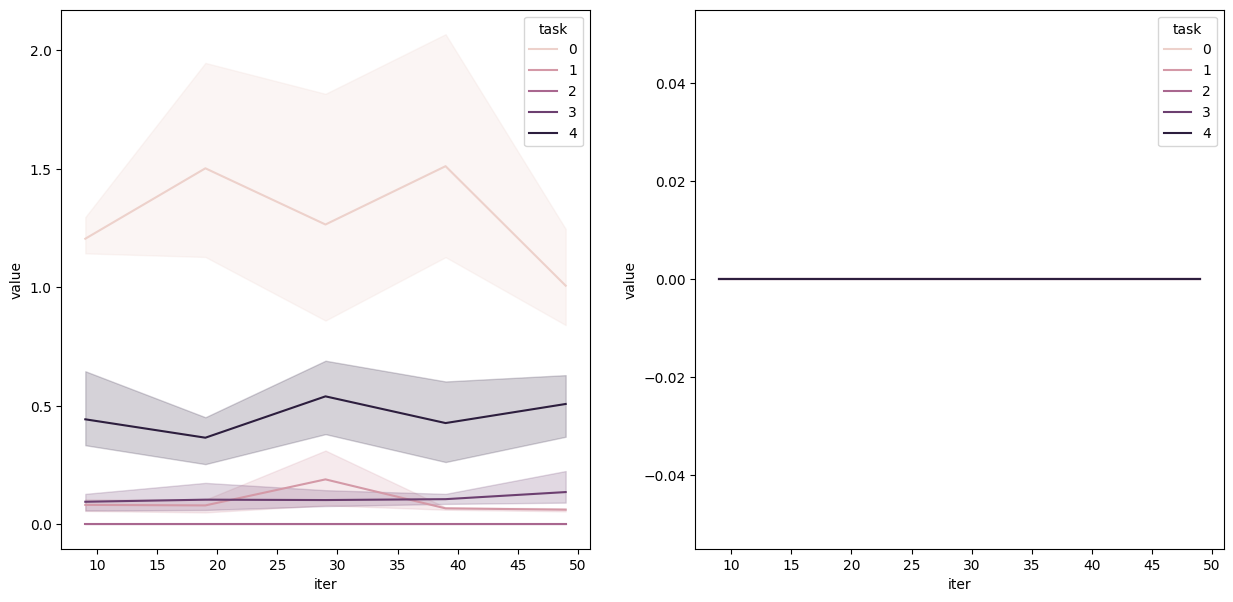

In [121]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

res = pd.concat([unpack_results(eval_results, i) for i in eval_results.keys()])

successes = res\
.query('metric=="success"')\
.groupby(['task', 'iter'])\
.agg(
    {
        'current_task':'max',
        'value': lambda x: sum(x) / len(x)
    }
)\
.reset_index()

rewards = res.query('metric=="episode_reward"')

fig, ax = plt.subplots(1,2, figsize = (15, 7))

sns.lineplot(
    data = rewards,
    x = 'iter',
    y = 'value',
    hue = 'task',
    ax = ax[0]
)

sns.lineplot(
    data = successes,
    x = 'iter',
    y = 'value',
    hue = 'task',
    ax = ax[1]
)

plt.show();

In [ ]:
pd.json_normalize(eval_results)

In [ ]:
import pandas as pd
df = pd.DataFrame(eval_results)
df

In [ ]:
pd.json_normalize(df.iloc[0, 0], max_level=0)

In [ ]:
[(k, [(i, pd.v) for i, v in v.items()]) for k, v in eval_results.items()]

In [ ]:
{{'iter': k, 'value': pd.json_normalize(v)} for k, v in eval_results.items()}

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# example training
### set the environment
env = training_envs[0]
### create a policy / actor critic
# policy_net = torch.load(RUN_FOLDER + '/models/policy.pt')
# we can update this
actor_critic = model.Policy(
    env.observation_space.shape,
    env.action_space,
    base_kwargs={'recurrent': True})
actor_critic.to(device)


### set algorithm
ppo_agent = ppo.PPO(
    actor_critic = actor_critic,
    clip_param = 0.2,
    ppo_epoch = 4,
    num_mini_batch = 10,
    value_loss_coef = 0.5,
    entropy_coef = 1.0e-5,
    lr = 1.0e-4,
    eps = 0.99,
    max_grad_norm = 0.5,
    use_clipped_value_loss = False
)

## create rollouts
rollouts = storage.RolloutStorage(
    10, 1, env.observation_space.shape, env.action_space, actor_critic.recurrent_hidden_state_size
)

# don't know
obs, _ = env.reset()
rollouts.obs[0].copy_(torch.from_numpy(obs))
rollouts.to(device)
episode_rewards = deque(maxlen = 10)

# actual training loop
start = time.time()
num_updates = 10
for j in range(num_updates):
    done = False
    step = 0
    while not done:
        with torch.no_grad():
            # this might be funny
            value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(rollouts.obs[step], rollouts.recurrent_hidden_states[step], rollouts.masks[step], None)
            step += 1

        # step the env
        obs, reward, truncated, terminated, info = env.step(action.detach().to('cpu').numpy()[0])
        done = truncated or terminated
